In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from dask.diagnostics import ProgressBar

# Load Data

## Capacity Data

In [3]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_mfdataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens*_1950-2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds_esm2m = ds_esm2m.rename({'__xarray_dataarray_variable__':'capacity'})

In [4]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base = lf.calc_baseline(ds_esm2m).compute()

[########################################] | 100% Completed | 37.6s


In [5]:
# Shorten capacity dataset to 2000-2100
ds_esm2m = ds_esm2m.sel(time=slice('2000-01-31',None))['capacity']

## Population/Land Area Data

In [5]:
# Population data
ds_pop = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m.nc')['population']
ds_pop = ds_pop.where(np.isfinite(ds_pop),0)
ds_pop = ds_pop.rename({'latitude':'lat','longitude':'lon'})

In [6]:
# Load area data
land_area = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask = np.isfinite(land_area)
# Replace NaN with 0 
land_area_adj = land_area.where(land_mask,0)

## Calculate ToEs

In [6]:
# Labor reduction thresholds and frequency threshold (# reduced months per year) used to define ToE
labor_thres = [0.9,0.8,0.7]
freq_thres = 3

# Calculate ToEs for all grid cells and ensemble members
with ProgressBar():
    ds_toe = lf.toe(ds_esm2m,ds_base,labor_thres,freq_thres).compute()

[########################################] | 100% Completed |  2min 40.4s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s


# Map Baseline Capacity

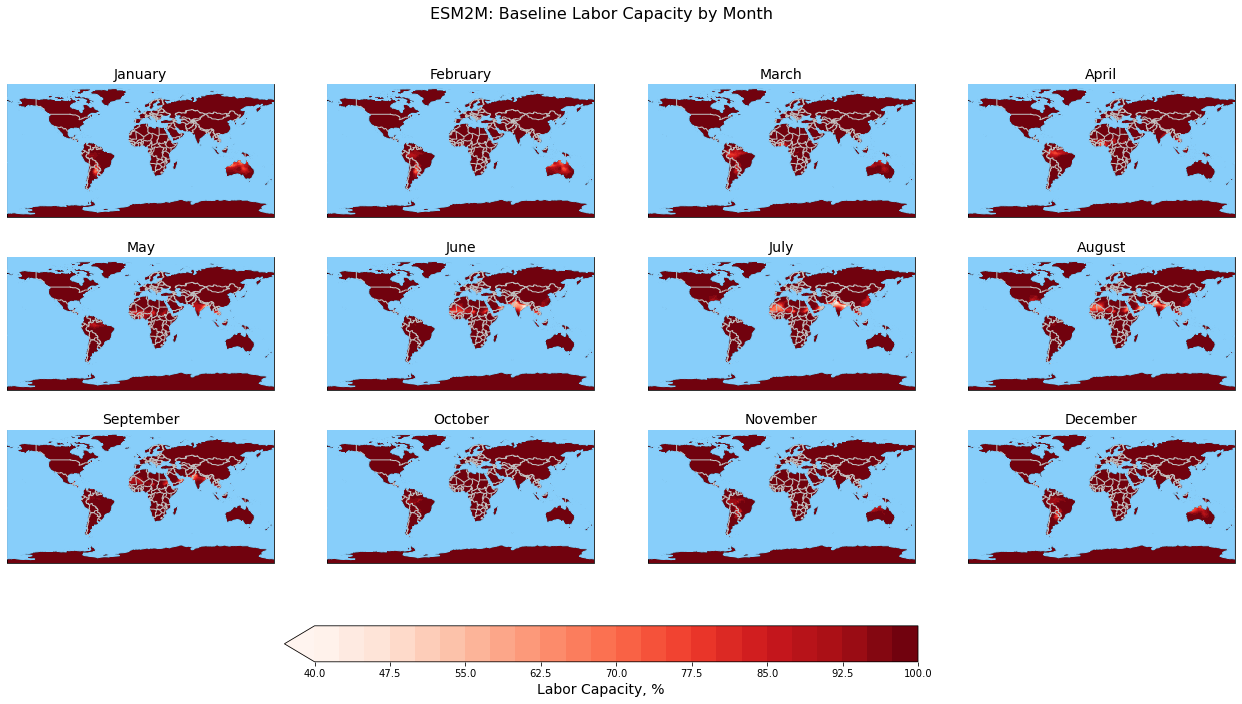

In [72]:
# Specify projection
crs = ccrs.PlateCarree()

# Create figure and axes
fig, axs = plt.subplots(ncols=4,nrows=3,figsize=(22,10),subplot_kw={'projection':crs})

levels = np.linspace(40,100,25)
cmap = 'Reds'
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for index in range(12):
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    im = lf.contour(ds_base.isel(month=index),months[index],ax,levels=levels,cmap =cmap,label='Year',extend='min')
    index+=1

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.07, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity, %',fontsize=14)

# Overall figure title
fig.suptitle('ESM2M: Baseline Labor Capacity by Month',fontsize=16);

# ToE Plots

## Spatial Maps

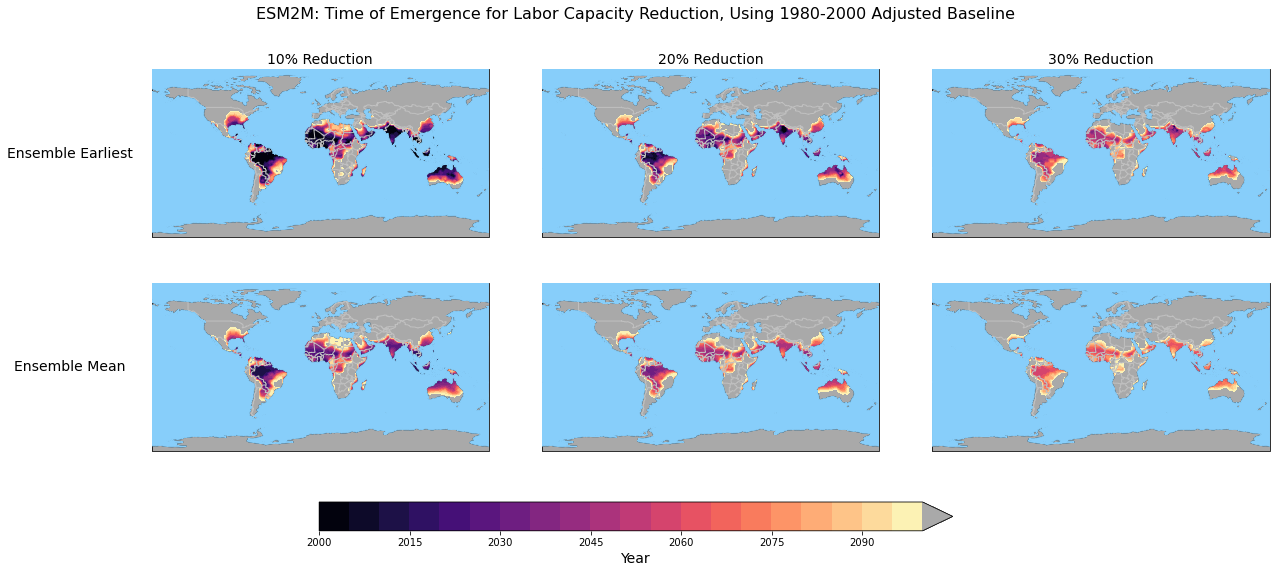

In [11]:
lf.spatial_toe(ds_toe,'ESM2M: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline')

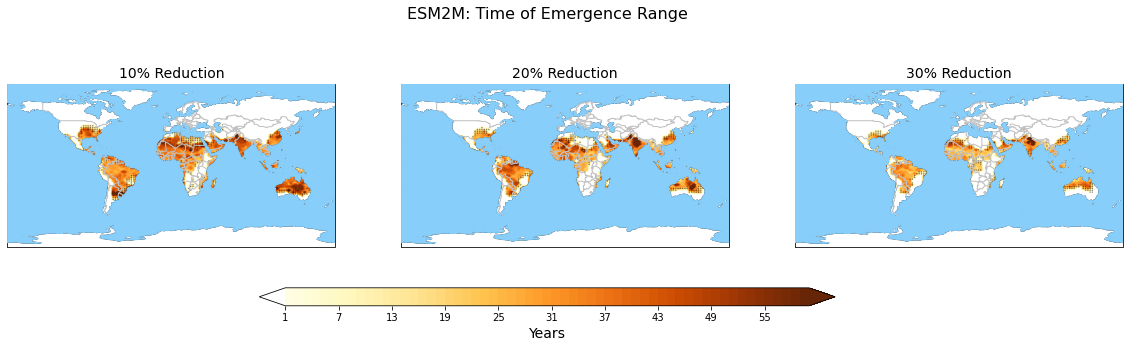

In [15]:
lf.spatial_toe_diff(ds_toe,'ESM2M: Time of Emergence Range')

# Bar Charts

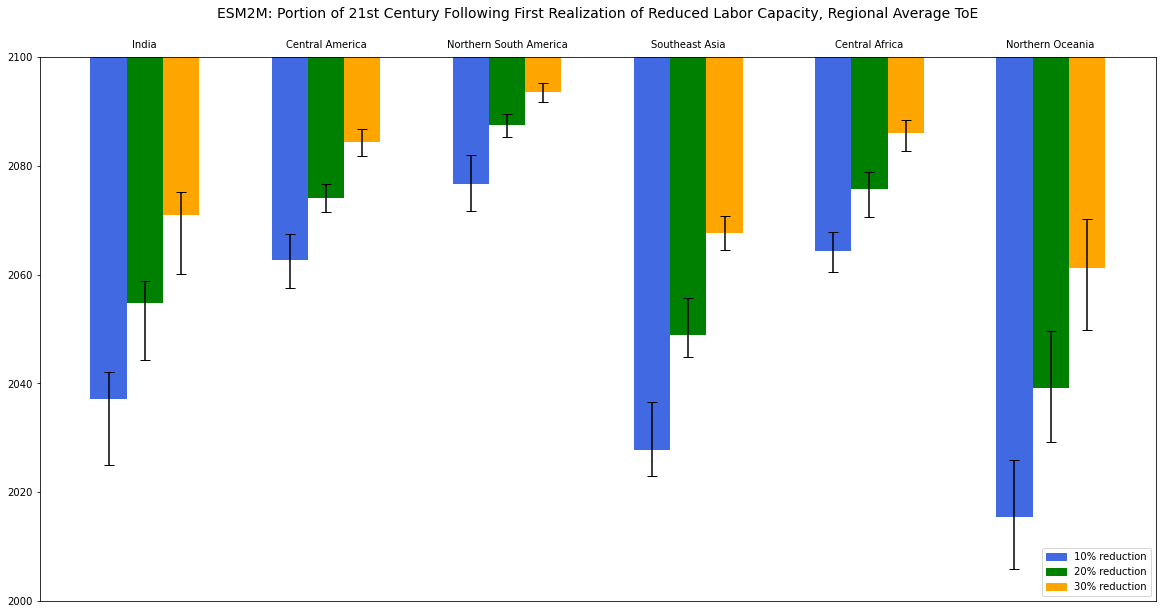

In [9]:
lf.average_toe_bar(ds_toe,ds_pop,'GFDL','ESM2M: Portion of 21st Century Following First Realization of Reduced Labor Capacity, Regional Average ToE\n')

[########################################] | 100% Completed | 44.0s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.7s
[########################################] | 100

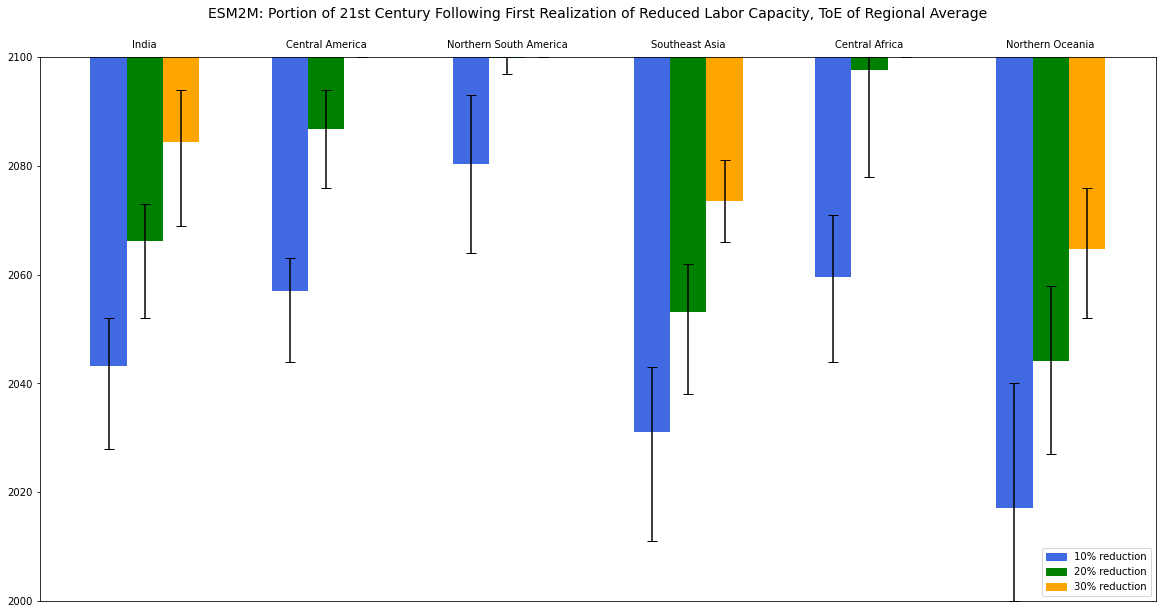

In [14]:
with ProgressBar():
    lf.toe_bar(ds_esm2m,ds_base,ds_pop,'GFDL','ESM2M: Portion of 21st Century Following First Realization of Reduced Labor Capacity, ToE of Regional Average\n',labor_thres,freq_thres)

## Time Series

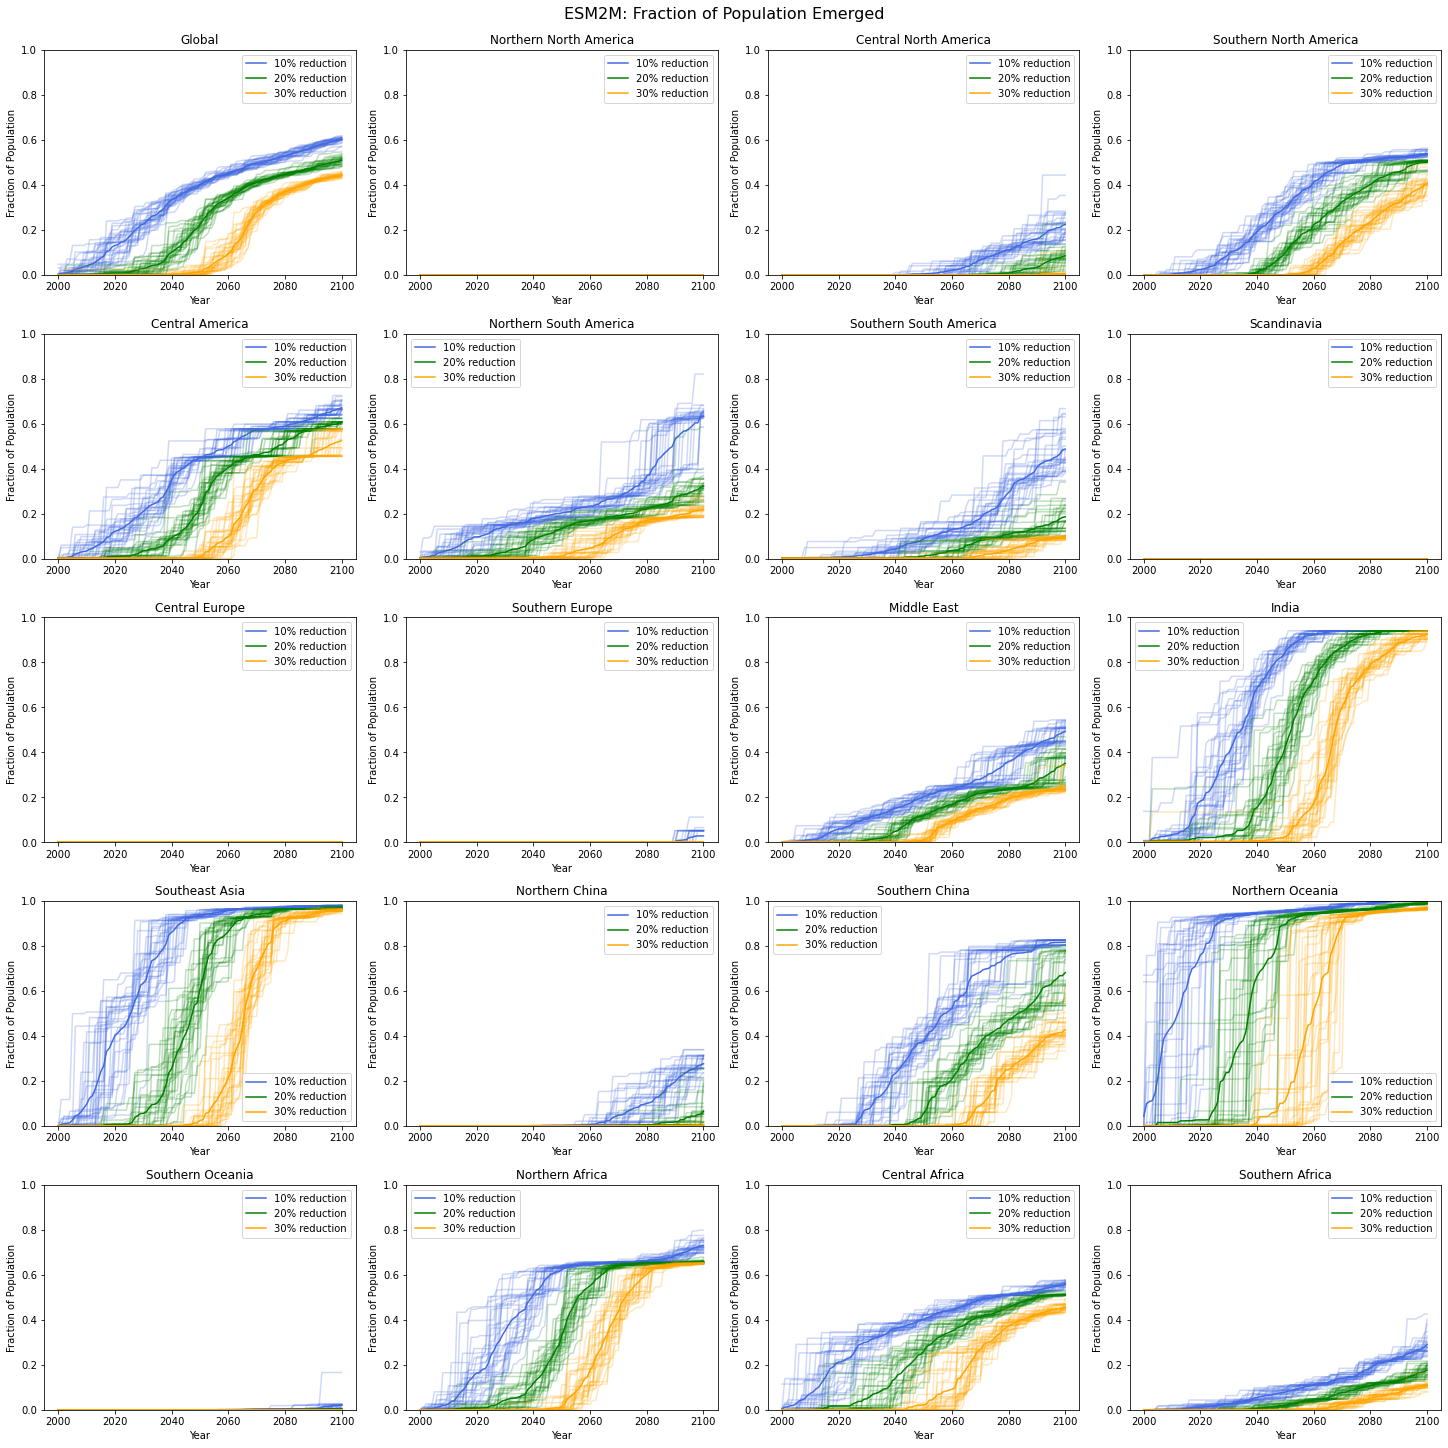

In [15]:
lf.frac_emerge_all(ds_toe,ds_pop,'GFDL','Fraction of Population','ESM2M: Fraction of Population Emerged')

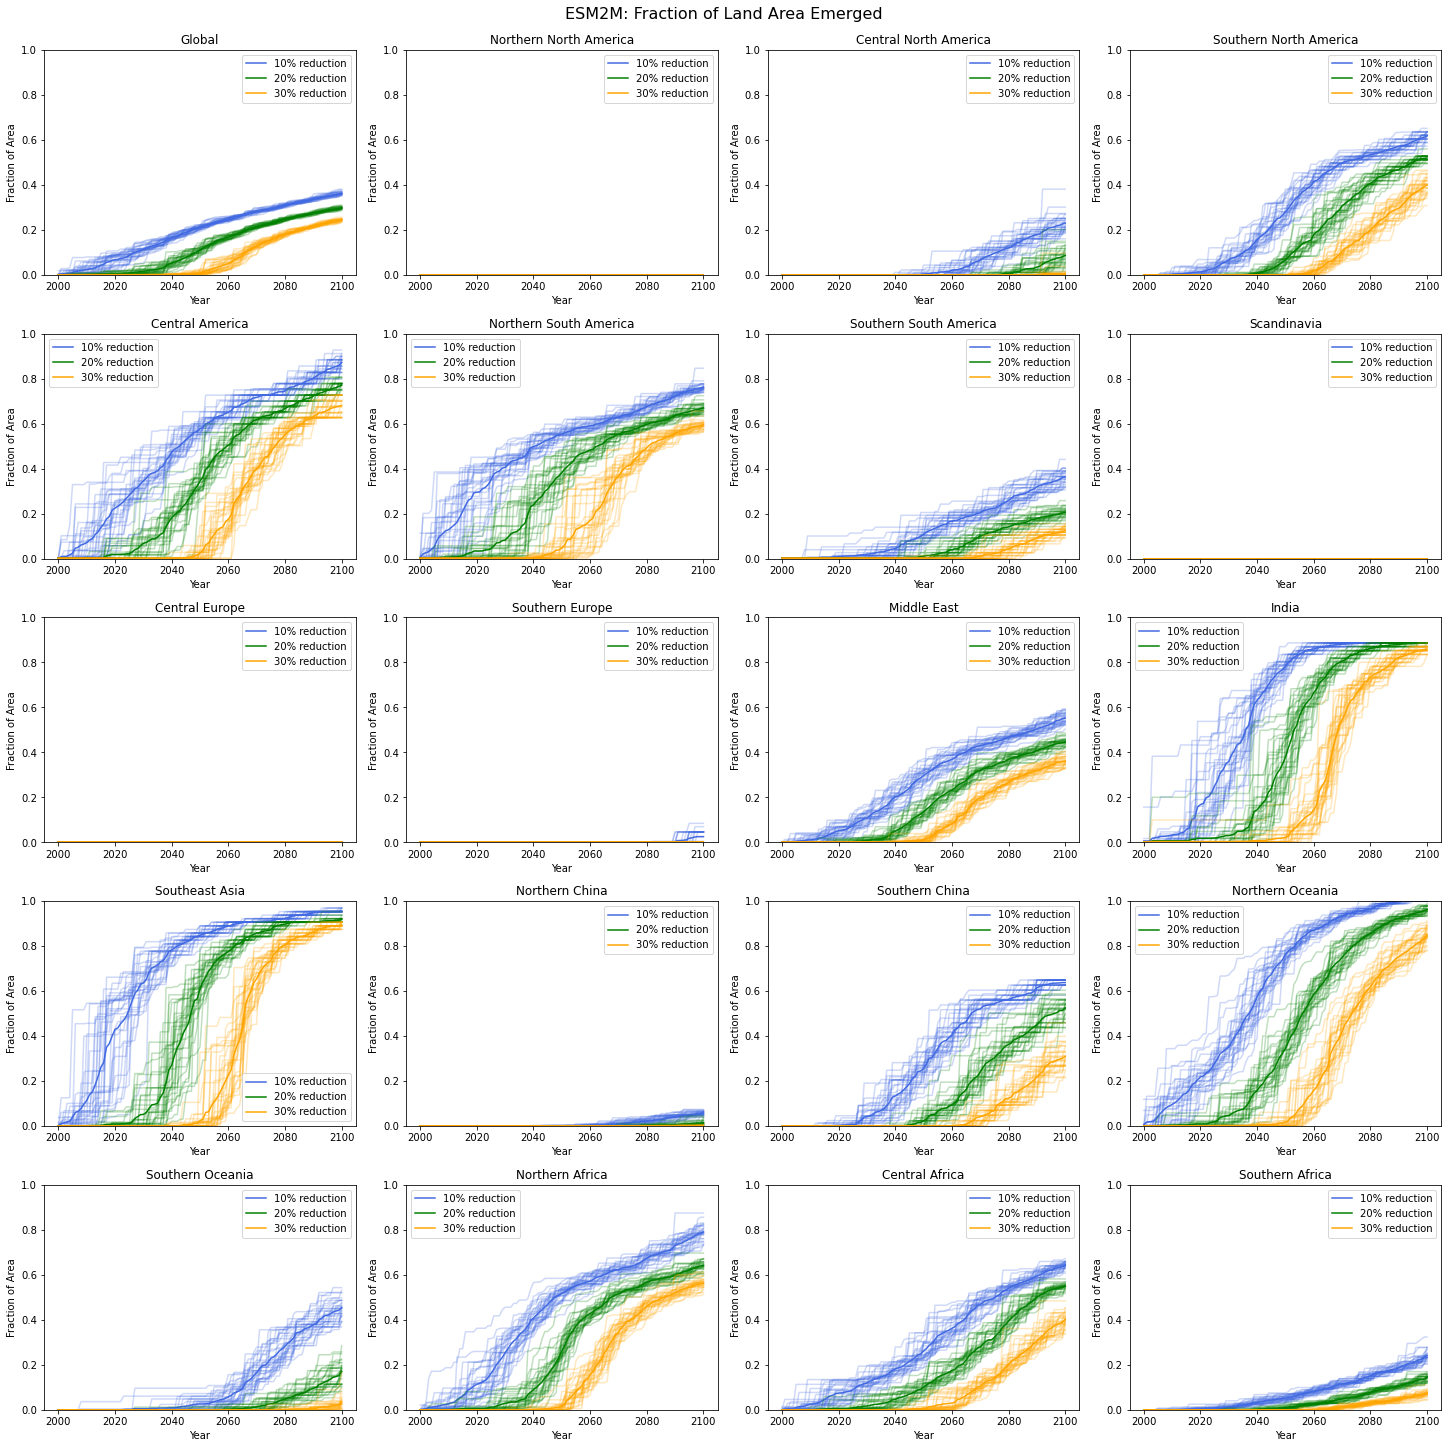

In [16]:
lf.frac_emerge_all(ds_toe,land_area_adj,'GFDL','Fraction of Area','ESM2M: Fraction of Land Area Emerged')

# Monthly Climatology

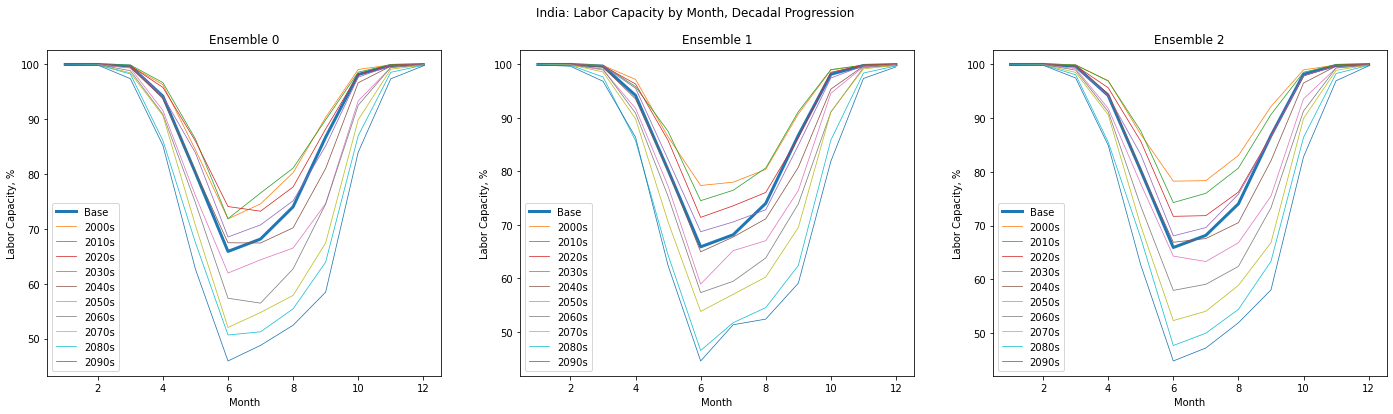

In [196]:
region = 'India'

fig,axs=plt.subplots(figsize=(24,6),ncols=3)

ds_region = lf.slice_region(ds_esm2m,region,'GFDL')
ds_region = ds_region.weighted(ds_pop).mean(['lat','lon'])

for ens in ds_region['ensemble'].values:
    ax = axs[ens]
    
    ds_ens = ds_region.sel(ensemble=ens)
    base_region = lf.slice_region(ds_base,region,'GFDL').weighted(ds_pop).mean(['lat','lon'])
    base_region.plot(ax=ax,linewidth=3)

    for index in range(0,10):
        ds_decade = ds_ens.isel(time=slice(index*120,index*120+120))
        ds_decade.groupby('time.month').mean().plot(ax=ax,linewidth=0.75)
    ax.set_xlabel('Month')
    ax.set_ylabel('Labor Capacity, %')
    ax.set_title('Ensemble ' + str(ens))
    ax.legend(['Base','2000s','2010s','2020s','2030s','2040s','2050s','2060s','2070s','2080s','2090s'])

    fig.suptitle(region + ': Labor Capacity by Month, Decadal Progression')